# Tweet Sentiment Analysis Project

by Garrett Williams, Dave McKinley and Ely Lin of Sphinx Consulting

## Overview

**Business Problem:**

In a world where technology startups are plentiful, consumer sentiment towards a brand can give us a lot of insights into their purchasing decisions, hence the financial performance of the company that makes them. Technology investment company WhiteOre have acquired our services to build them a predictive model that monitors recent tweets on technology products to help them make informed investment decisions. WhiteOre wants a generalizable model to gauge sentiment across different brands, to act as a filtering system to help decide which brands to investigate further for possible investment. WhiteOre only cares about whether people have positive emotions towards the brand because people buy things they like. 


**Target Audience:**

The hedge fund and private equity department of WhiteOre

**Context:**

False positive in this case would mean our model predicts that a consumer has positive emotions towards a brand but they actually don't, leading to overvaluing of a potential investment opportunity and wasting human capital.

False negative in this case would mean our model predicts that a consumer doesn't have positive emotions towards a brand but they actually do, leading to missing a potential investment opportunity.

**Evaluation:**

We don't want to overvalue or undervalue a company, however, the cost of missing the opportunity of getting in early on a good brand that's generating buzz is bigger than spending human resources to evaluate a company and finding out it's not worth investing in. Therefore, we care about maximizing accuracy as well as recall.

**Data Understanding:**

The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither. The tweets included are sent out during the South by South West conference in 2013, mostly about Google and Apple products.

Data source: https://data.world/crowdflower/brands-and-product-emotions

**Modeling**

We used nltk's tweet tokenizer to tokenize the tweets and tfidf vectorizer to vectorize them. 

Modeling techniques include logistic regression, decision trees, random forest, naive bayes, catboost and neural network. 

**Evaluation**

We are able to achieve above 70% accuracy on both training data and testing data on both our naive bayes and neural netword models without overfitting. However, naive bayes requires significantly less computational power so we decide to use naive bayes as our final model. 

## Business Understanding

## Data Understanding

In [81]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

In [82]:
# !pip install catboost

In [83]:
#load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [84]:
#rename columns for readability
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head() #Sanity Check

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [85]:
#looking at data, duplicates and null values
print(df.info())
print(("-"*20))
print(df.duplicated().sum())
print(("-"*20))
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
22
--------------------
Tweet           1
Product      5802
Sentiment       0
dtype: int64


In [86]:
#Simplify sentiment labels for visualizations
dict_sent = {'No emotion toward brand or product':"No emotion", 
             'Positive emotion':'Positive emotion',
             'Negative emotion':'Negative emotion',
             "I can't tell": "I can't tell"}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [87]:
#sentiment breakdown
df['Sentiment'].value_counts() 

No emotion          5389
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: Sentiment, dtype: int64

In [88]:
#number of tweets per product
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [89]:
#drop any NaN in the Tweet column
df['Tweet'].dropna(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [90]:
#drop duplicates
df.drop_duplicates(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [91]:
#drops Tweets with nonsensical characters
df.drop([6, 9092], inplace=True)

In [92]:
#reset the index after cleaning
df.reset_index(inplace=True)
df.drop(columns="index", inplace = True)

In [93]:
#looks at cleaned dataframe
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",NaN,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9067,"Google's Zeiger, a physician never reported po...",NaN,No emotion


In [94]:
#looks at remaining NaN's
print(df.isna().sum())

Tweet           0
Product      5787
Sentiment       0
dtype: int64


In [95]:
#Fills NaN's with "Undefined" to help with data visualizations
df['Product'].fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


In [96]:
#Fills NaN's with "Undefined" to help with data visualizations
df.Product.fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


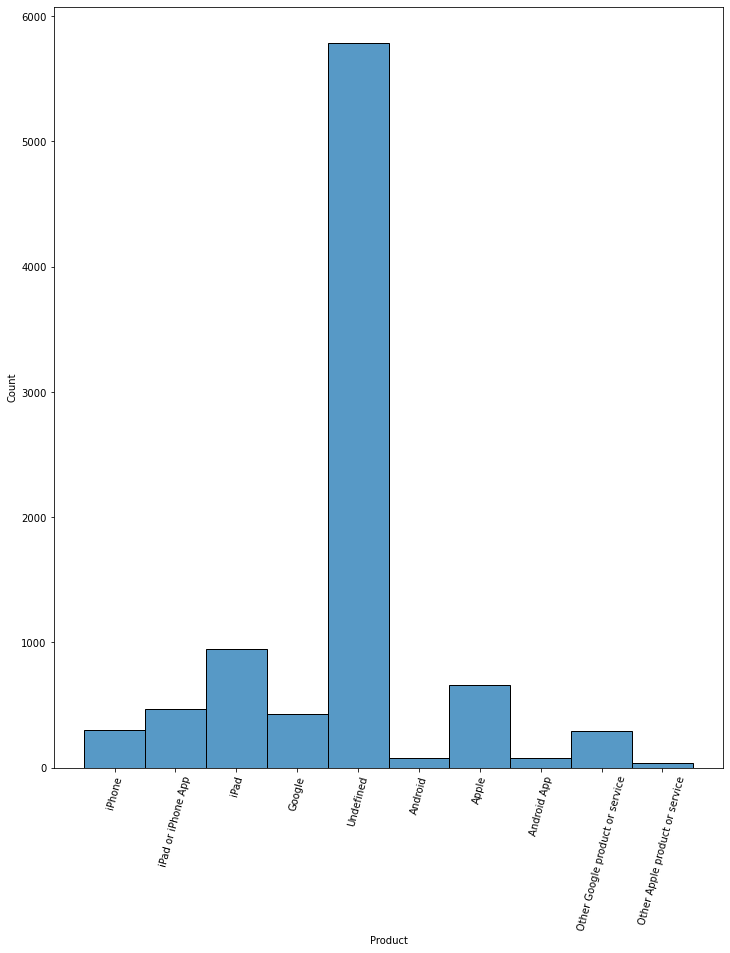

In [97]:
fig, ax = plt.subplots(figsize=(12,14))
sns.histplot(df["Product"] )
plt.xticks(rotation = 75)
plt.show()

In [98]:
#we are going to set the Product type as a string for our function below.
df["Product"].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9064             Undefined
9065                  iPad
9066             Undefined
9067             Undefined
9068             Undefined
Name: Product, Length: 9069, dtype: object

In [99]:
def find_brand(Product, Tweet):
    """
    This function is designed to take build a brand column based on the Product description. 
    After, the function will look at the Tweets and determine a brand for rows with no brand determined.
    
    Product -  a column teh function is working on
    Tweet - a column teh function is working on
    """
    brand = 'Undetermined' #Labeling brand as Undetermined
    if ((Product.lower().__contains__('google')) or (Product.lower().__contains__('android'))): #Labeling Google
        brand = 'Google' #Unless tweet contains google or android
    elif ((Product.lower().__contains__('apple')) or (Product.lower().__contains__('ip'))): #Labeling Apple
        brand = 'Apple' #Unless tweet contains apple or ip
    
    if (brand == 'Undetermined'): 
        lower_tweet = Tweet.lower() #Making tweet lowercase
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [100]:
#Sanity Check
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [101]:
def countplot(df, col, hue=None, rotation=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
    ax.set_title(f"Number of Tweets per {col}", fontsize = 30)
    plt.show()

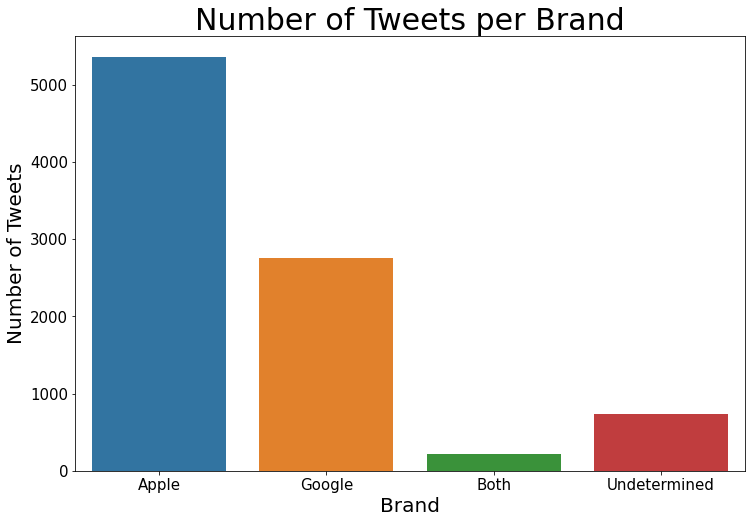

In [102]:
#countplot for Brand
countplot(df, "Brand")

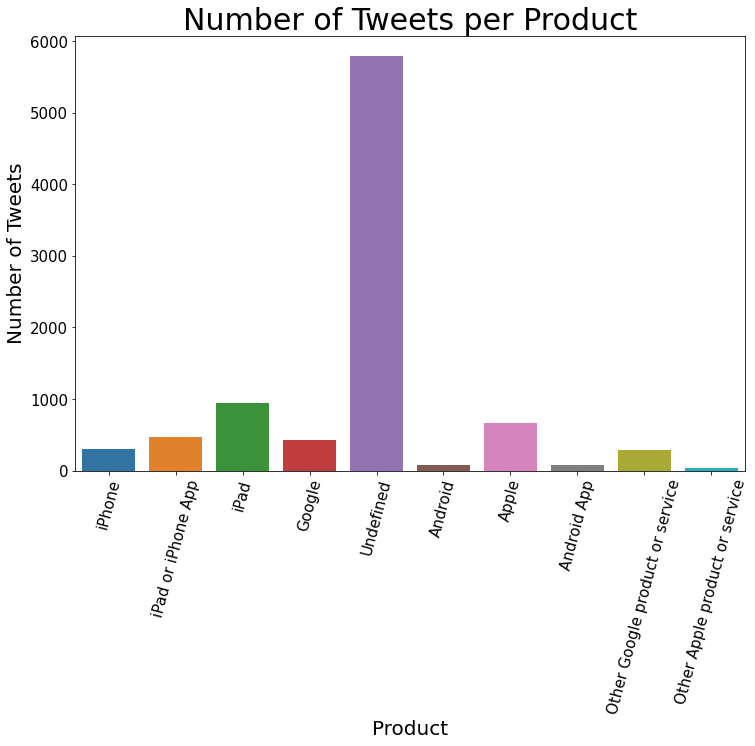

In [103]:
#countplot for Product
countplot(df, "Product", hue=None, rotation=75)

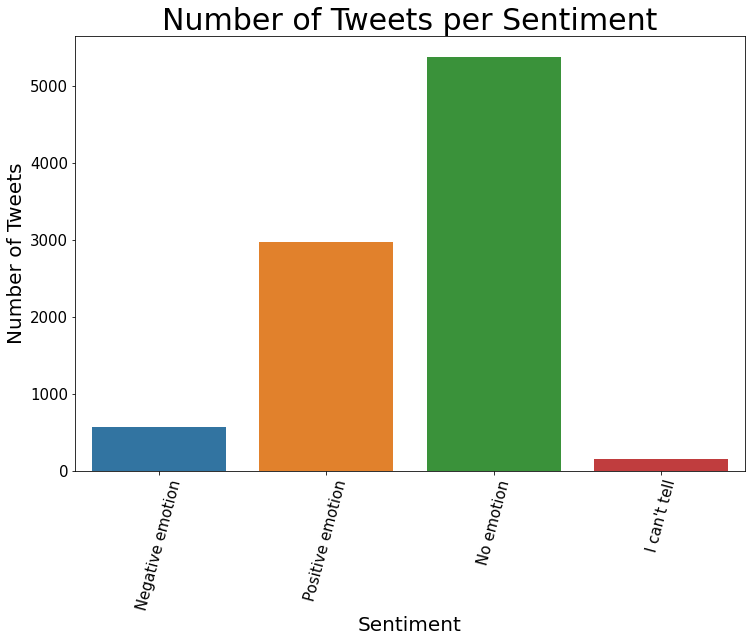

In [104]:
# Count plot for sentiment
countplot(df, "Sentiment", rotation = 75)

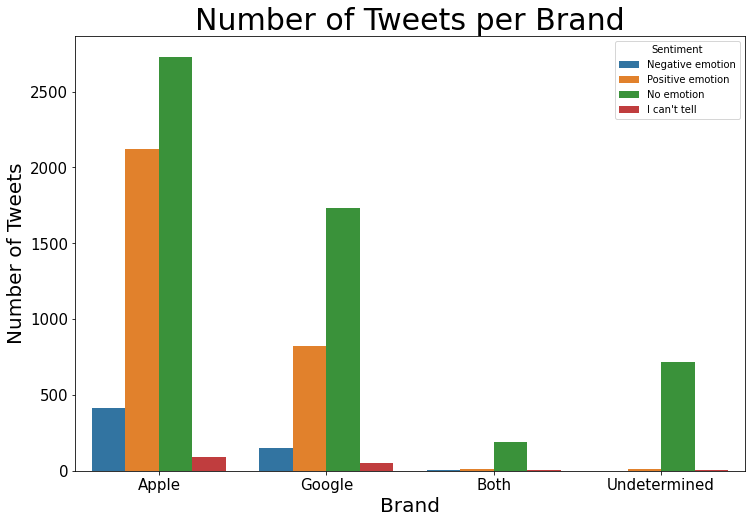

In [105]:
#count plot for Sentiment across brands
countplot(df, "Brand", hue = "Sentiment")

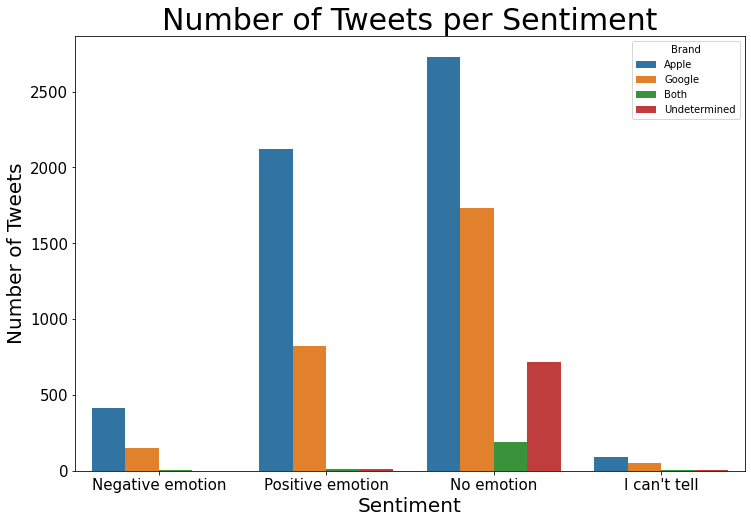

In [106]:
#countplot for brand make of sentiment
countplot(df, "Sentiment", hue="Brand")

In [107]:
#looking at the number of tweets per brand per sentiment
grouped = df.groupby(["Brand", "Sentiment"]).count()
grouped

Tweet  Product
Brand        Sentiment                       
Apple        I can't tell         93       93
             Negative emotion    415      415
             No emotion         2730     2730
             Positive emotion   2123     2123
Both         I can't tell          7        7
             Negative emotion      3        3
             No emotion          192      192
             Positive emotion     11       11
Google       I can't tell         50       50
             Negative emotion    150      150
             No emotion         1733     1733
             Positive emotion    823      823
Undetermined I can't tell          6        6
             Negative emotion      1        1
             No emotion          719      719
             Positive emotion     13       13

In [108]:
#looking at sentitmental breakdown of brands
display(df.groupby(['Sentiment'])['Brand'].value_counts(normalize = True))
print("-"*60)
display(df.groupby(['Brand'])['Sentiment'].value_counts(normalize = True))

Sentiment         Brand       
I can't tell      Apple           0.596154
                  Google          0.320513
                  Both            0.044872
                  Undetermined    0.038462
Negative emotion  Apple           0.729350
                  Google          0.263620
                  Both            0.005272
                  Undetermined    0.001757
No emotion        Apple           0.508001
                  Google          0.322479
                  Undetermined    0.133792
                  Both            0.035728
Positive emotion  Apple           0.714815
                  Google          0.277104
                  Undetermined    0.004377
                  Both            0.003704
Name: Brand, dtype: float64

------------------------------------------------------------


Brand         Sentiment       
Apple         No emotion          0.509233
              Positive emotion    0.396008
              Negative emotion    0.077411
              I can't tell        0.017348
Both          No emotion          0.901408
              Positive emotion    0.051643
              I can't tell        0.032864
              Negative emotion    0.014085
Google        No emotion          0.628810
              Positive emotion    0.298621
              Negative emotion    0.054427
              I can't tell        0.018142
Undetermined  No emotion          0.972936
              Positive emotion    0.017591
              I can't tell        0.008119
              Negative emotion    0.001353
Name: Sentiment, dtype: float64

In [109]:
#Number of Tweets per product
df["Product"].value_counts()

Undefined                          5787
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product, dtype: int64

In [110]:
#Number of Tweets per Sentiment
df["Sentiment"].value_counts()

No emotion          5374
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: Sentiment, dtype: int64

In [111]:
#Number of Tweet per Brand
df["Brand"].value_counts()

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [112]:
#Final DataFrame before Preprocessing
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


## Data Preprocessing

In [113]:
#Turn our Target into a Binary number
dict_sent = {'No emotion':0, 
             'Positive emotion':1,
             'Negative emotion':0,
             "I can't tell": 0}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [114]:
#Create the X DataFrame with only the tweets
X = df[['Tweet']]
#Create the y Series with only the sentiments, 1 for Positive, 0 for not Positive
y = df['Sentiment']
#First train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#Second train test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

Doing the train-test split before the Data Preprocessing prevents data leakage.

In [115]:
#Baseline Understanding
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

In [116]:
#Check first few rows in X_train
X_train.head()

,Tweet
2320,@mention Can we make you an iPhone case with T...
5622,RT @mention Come party down with @mention &amp...
1748,#winning #winning - just gave away 5 red mophi...
5789,RT @mention google &amp; facebook have an offi...
3334,Rumor of Google launching their new social net...


In [117]:
#Check how many rows X_train has
X_train.shape

(6121, 1)

In [118]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
stopwords_list.append("sxsw") #remove sxsw because it's the hashtag for the event
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [119]:
def clean_tweets(text):
    #Use TweetTokenizer object to remove the handles from the Tweet
    #TweetTokenizer also puts each punctuation as it's own token
    no_handle = tweet_tknzr.tokenize(text)
    #Join the list of non-handle tokens back together
    tweet = " ".join(no_handle) 
    #remove http websites, hashtag sign, any words in curly brackets,
        #any words with ampersand in front, www dot com websites, links,
        #videos, and non-english characters
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    #Turn all the tokens lowercase
    lower = clean.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return cleaned_string

In [120]:
#Sanity Check
clean_tweets(X_train['Tweet'].iloc[0])

'make iphone case ttye time want show support'

In [121]:
#Apply our clean_tweets function to X_train, X_val, X_test
X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_57180/2577958706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_57180/2577958706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))


In [122]:
#Sanity Check
X_train

,Tweet
2320,make iphone case ttye time want show support
5622,come party google tonight link band food art i...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...
...,...
5692,even security guard austin enjoy ipad time link
8582,attending want explore austin check austin lin...
7815,apple popup store link gonnagetanipad2
7483,putting pop apple store smart talk understandi...


In [123]:
y_train

2320    0
5622    1
1748    0
5789    0
3334    0
       ..
5692    1
8582    0
7815    0
7483    1
3531    0
Name: Sentiment, Length: 6121, dtype: int64

In [124]:
X_val

,Tweet
888,hootsuite mobile update iphone blackberry andr...
4191,morning hearing google circle today link
2161,great location choice nice timing ipad launch ...
1882,win ipad via link
4693,launching product plenty else join h4ckers 80 ...
...,...
1030,racing around best fueling great local fare ea...
4179,omg still line new ipad dieing hunger else line
7714,hour popup apple store lone security guard enj...
8190,great app interface example moma target flipbo...


In [125]:
y_val

888     0
4191    0
2161    1
1882    1
4693    0
       ..
1030    0
4179    1
7714    0
8190    1
4510    0
Name: Sentiment, Length: 2041, dtype: int64

## Modeling

### 1st Iteration: Simple Naive Bayes

In [152]:
#Create a pipeline to use an Untuned TfidfVectorizer() and MultinomialNB()
pipe_nb = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Cross validate
cv_nb = cross_validate(pipe_nb, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb

{'fit_time': array([0.24101472, 0.175524  , 0.11101079, 0.21603155, 0.14902329]),
 'score_time': array([0.10500741, 0.04800701, 0.04300904, 0.12600946, 0.04900289]),
 'test_accuracy': array([0.70612245, 0.70506536, 0.69934641, 0.69444444, 0.70915033]),
 'train_accuracy': array([0.78696895, 0.7945681 , 0.78742087, 0.79252604, 0.79048397]),
 'test_recall': array([0.15365239, 0.14646465, 0.12626263, 0.13636364, 0.16161616]),
 'train_recall': array([0.35669192, 0.38170347, 0.35772871, 0.37223975, 0.36719243]),
 'test_roc_auc': array([0.73155094, 0.6767448 , 0.69595411, 0.70236178, 0.70092379]),
 'train_roc_auc': array([0.88950838, 0.89780161, 0.89179296, 0.89564979, 0.89119786])}

In [153]:
#Get mean accuracy for validation set
cv_nb['test_accuracy'].mean()

0.7028257969854609

In [154]:
pipe_nb.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('nb', MultinomialNB())])

In [155]:
cross_validate(pipe_nb, X_train, y_train, return_train_score=True, scoring="recall")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py", line 612, in fit
    X, y = self._check_X_y(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py", line 477, in _check_X_y
    return self._validate_data(X, y, accept_sparse='csr')
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sk

{'fit_time': array([0.00700283, 0.00599599, 0.00800085, 0.00600553, 0.00800109]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan]),
 'train_score': array([nan, nan, nan, nan, nan])}

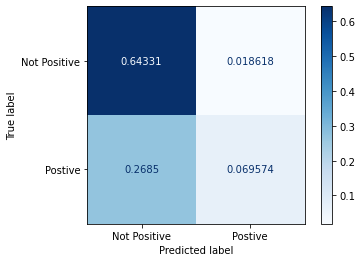

In [165]:
plot_confusion_matrix(pipe_nb, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 2nd Iteration: Naive Bayes with a tuned TfidfVectorizer

In [157]:
#Create a pipeline to use an Tuned TfidfVectorizer() and MultinomialNB()
pipe_nb_tuned = Pipeline(steps=[
    ('tfidf_vectorizer_tuned', TfidfVectorizer(max_df=.99,min_df=0.003, max_features=1000)),
    ('nb_tuned', MultinomialNB(alpha=.1))
])
#Cross validate
cv_nb_tuned = cross_validate(pipe_nb_tuned, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb_tuned

{'fit_time': array([0.25901651, 0.13001013, 0.12843466, 0.09400797, 0.11300588]),
 'score_time': array([0.09900808, 0.06001115, 0.10200763, 0.09700751, 0.06800771]),
 'test_accuracy': array([0.72897959, 0.70506536, 0.72222222, 0.69444444, 0.71568627]),
 'train_accuracy': array([0.73897059, 0.74555851, 0.73187666, 0.74310803, 0.73514397]),
 'test_recall': array([0.26448363, 0.23989899, 0.25757576, 0.23737374, 0.22222222]),
 'train_recall': array([0.30239899, 0.31861199, 0.27003155, 0.31167192, 0.28769716]),
 'test_roc_auc': array([0.71332701, 0.67444981, 0.68969435, 0.6784893 , 0.67984647]),
 'train_roc_auc': array([0.76477105, 0.77150663, 0.76517844, 0.76901536, 0.76902355])}

In [158]:
#Get mean accuracy for validation set
cv_nb_tuned['test_accuracy'].mean()

0.713279578498066

In [159]:
pipe_nb_tuned.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer_tuned',
                 TfidfVectorizer(max_df=0.99, max_features=1000, min_df=0.003)),
                ('nb_tuned', MultinomialNB(alpha=0.1))])

In [160]:
cross_validate(pipe_nb_tuned, X_train, y_train, return_train_score=True, scoring="recall")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 

{'fit_time': array([0.0049994 , 0.00399685, 0.00500417, 0.00500154, 0.00500131]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan]),
 'train_score': array([nan, nan, nan, nan, nan])}

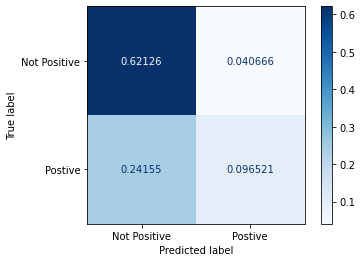

In [164]:
plot_confusion_matrix(pipe_nb_tuned, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 3rd Iteration: Logistic Regression with PCA

In [132]:
#Create a tuned tfidf vectorizer that will be scaled for PCA
tfidf_vectorizer_tuned = TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)

#Fit vectorizer on X_train
tfidf_vectorizer_tuned.fit(X_train['Tweet'])

#Transform X_train and X_val
X_train_tfidf_vec = tfidf_vectorizer_tuned.transform(X_train['Tweet'])
X_val_tfidf_vec = tfidf_vectorizer_tuned.transform(X_val['Tweet'])

#Turn X_train and X_val into DataFrame
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray())

In [133]:
#Create a StandardScaler Object
scaler = StandardScaler()

#Fit scaler to tuned vectorized X_train and transform both X_train and X_val
X_train_scaled = scaler.fit_transform(X_train_tfidf_vec_df)
X_val_scaled = scaler.transform(X_val_tfidf_vec_df)

In [134]:
#Create a PCA object
pca = PCA(n_components = .99, random_state=42)

In [135]:
#Create a Pipeline object for PCA and Logistic Regression
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=42, max_iter=1000))])
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [136]:
#Check results
print("PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes")
print(pipe_lr.score(X_train_scaled, y_train))
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes
0.7250449272994609
0.7099461048505634


In [140]:
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [145]:
cross_validate(pipe_lr, X_train_scaled, y_train, return_train_score=True, scoring="recall")

{'fit_time': array([0.45003104, 0.48503876, 0.47803926, 0.49447632, 0.48114562]),
 'score_time': array([0.01199889, 0.01600003, 0.01399684, 0.01600432, 0.01700163]),
 'test_score': array([0.35012594, 0.32828283, 0.35353535, 0.31565657, 0.33333333]),
 'train_score': array([0.38005051, 0.39495268, 0.36971609, 0.38548896, 0.38485804])}

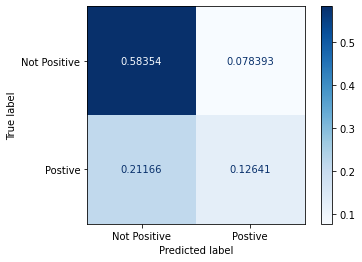

In [166]:
plot_confusion_matrix(pipe_lr, X_val_scaled, y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 4th Iteration: CatBoost

In [170]:
#Create a pipeline with CatBoost
pipe_cbc = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer(max_df=.99,min_df=0.0005, max_features=1000)),
    ('cbc', CatBoostClassifier())
])
#Cross Validate
cv_cbc = cross_validate(pipe_cbc, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
cv_cbc

Learning rate set to 0.0203
0:	learn: 0.6902882	total: 43.5ms	remaining: 43.5s
1:	learn: 0.6873132	total: 83.6ms	remaining: 41.7s
2:	learn: 0.6846064	total: 122ms	remaining: 40.6s
3:	learn: 0.6819889	total: 158ms	remaining: 39.4s
4:	learn: 0.6794833	total: 202ms	remaining: 40.1s
5:	learn: 0.6766114	total: 248ms	remaining: 41s
6:	learn: 0.6740722	total: 284ms	remaining: 40.3s
7:	learn: 0.6720902	total: 328ms	remaining: 40.7s
8:	learn: 0.6694389	total: 374ms	remaining: 41.2s
9:	learn: 0.6673317	total: 411ms	remaining: 40.7s
10:	learn: 0.6650526	total: 449ms	remaining: 40.4s
11:	learn: 0.6630197	total: 485ms	remaining: 40s
12:	learn: 0.6611200	total: 518ms	remaining: 39.4s
13:	learn: 0.6592143	total: 552ms	remaining: 38.9s
14:	learn: 0.6574584	total: 593ms	remaining: 38.9s
15:	learn: 0.6557285	total: 638ms	remaining: 39.3s
16:	learn: 0.6541164	total: 678ms	remaining: 39.2s
17:	learn: 0.6525168	total: 720ms	remaining: 39.3s
18:	learn: 0.6509141	total: 765ms	remaining: 39.5s
19:	learn: 0.64

161:	learn: 0.5792263	total: 5.36s	remaining: 27.7s
162:	learn: 0.5790983	total: 5.39s	remaining: 27.7s
163:	learn: 0.5788402	total: 5.43s	remaining: 27.7s
164:	learn: 0.5786935	total: 5.46s	remaining: 27.6s
165:	learn: 0.5785465	total: 5.5s	remaining: 27.6s
166:	learn: 0.5783247	total: 5.54s	remaining: 27.6s
167:	learn: 0.5781191	total: 5.56s	remaining: 27.6s
168:	learn: 0.5779478	total: 5.6s	remaining: 27.5s
169:	learn: 0.5777905	total: 5.64s	remaining: 27.5s
170:	learn: 0.5775882	total: 5.67s	remaining: 27.5s
171:	learn: 0.5773660	total: 5.69s	remaining: 27.4s
172:	learn: 0.5771762	total: 5.72s	remaining: 27.4s
173:	learn: 0.5770290	total: 5.76s	remaining: 27.4s
174:	learn: 0.5768644	total: 5.8s	remaining: 27.4s
175:	learn: 0.5766318	total: 5.84s	remaining: 27.3s
176:	learn: 0.5764919	total: 5.88s	remaining: 27.3s
177:	learn: 0.5762742	total: 5.92s	remaining: 27.3s
178:	learn: 0.5760944	total: 5.95s	remaining: 27.3s
179:	learn: 0.5758851	total: 5.99s	remaining: 27.3s
180:	learn: 0.5

320:	learn: 0.5543561	total: 10.9s	remaining: 23.1s
321:	learn: 0.5542187	total: 10.9s	remaining: 23s
322:	learn: 0.5540584	total: 11s	remaining: 23s
323:	learn: 0.5539100	total: 11s	remaining: 23s
324:	learn: 0.5537937	total: 11s	remaining: 22.9s
325:	learn: 0.5535959	total: 11.1s	remaining: 22.9s
326:	learn: 0.5534536	total: 11.1s	remaining: 22.9s
327:	learn: 0.5533161	total: 11.2s	remaining: 22.9s
328:	learn: 0.5531873	total: 11.2s	remaining: 22.8s
329:	learn: 0.5530725	total: 11.2s	remaining: 22.8s
330:	learn: 0.5529600	total: 11.3s	remaining: 22.8s
331:	learn: 0.5527996	total: 11.3s	remaining: 22.7s
332:	learn: 0.5526661	total: 11.3s	remaining: 22.7s
333:	learn: 0.5525531	total: 11.4s	remaining: 22.7s
334:	learn: 0.5524214	total: 11.4s	remaining: 22.7s
335:	learn: 0.5521781	total: 11.5s	remaining: 22.7s
336:	learn: 0.5520488	total: 11.5s	remaining: 22.7s
337:	learn: 0.5519263	total: 11.6s	remaining: 22.6s
338:	learn: 0.5517800	total: 11.6s	remaining: 22.6s
339:	learn: 0.5516121	to

482:	learn: 0.5305819	total: 16.6s	remaining: 17.8s
483:	learn: 0.5303529	total: 16.6s	remaining: 17.7s
484:	learn: 0.5302016	total: 16.7s	remaining: 17.7s
485:	learn: 0.5300791	total: 16.7s	remaining: 17.7s
486:	learn: 0.5299691	total: 16.7s	remaining: 17.6s
487:	learn: 0.5298644	total: 16.8s	remaining: 17.6s
488:	learn: 0.5297574	total: 16.8s	remaining: 17.5s
489:	learn: 0.5295836	total: 16.8s	remaining: 17.5s
490:	learn: 0.5293278	total: 16.9s	remaining: 17.5s
491:	learn: 0.5292087	total: 16.9s	remaining: 17.4s
492:	learn: 0.5290549	total: 16.9s	remaining: 17.4s
493:	learn: 0.5289207	total: 16.9s	remaining: 17.3s
494:	learn: 0.5287973	total: 17s	remaining: 17.3s
495:	learn: 0.5286839	total: 17s	remaining: 17.3s
496:	learn: 0.5284810	total: 17s	remaining: 17.2s
497:	learn: 0.5283838	total: 17.1s	remaining: 17.2s
498:	learn: 0.5282806	total: 17.1s	remaining: 17.2s
499:	learn: 0.5281344	total: 17.1s	remaining: 17.1s
500:	learn: 0.5280174	total: 17.2s	remaining: 17.1s
501:	learn: 0.5278

647:	learn: 0.5058952	total: 21.9s	remaining: 11.9s
648:	learn: 0.5057353	total: 21.9s	remaining: 11.9s
649:	learn: 0.5055218	total: 22s	remaining: 11.8s
650:	learn: 0.5053608	total: 22s	remaining: 11.8s
651:	learn: 0.5052155	total: 22s	remaining: 11.8s
652:	learn: 0.5050833	total: 22.1s	remaining: 11.7s
653:	learn: 0.5049812	total: 22.1s	remaining: 11.7s
654:	learn: 0.5047877	total: 22.1s	remaining: 11.7s
655:	learn: 0.5046418	total: 22.2s	remaining: 11.6s
656:	learn: 0.5044981	total: 22.2s	remaining: 11.6s
657:	learn: 0.5043681	total: 22.3s	remaining: 11.6s
658:	learn: 0.5043056	total: 22.3s	remaining: 11.5s
659:	learn: 0.5041918	total: 22.3s	remaining: 11.5s
660:	learn: 0.5040121	total: 22.4s	remaining: 11.5s
661:	learn: 0.5039000	total: 22.4s	remaining: 11.4s
662:	learn: 0.5038199	total: 22.4s	remaining: 11.4s
663:	learn: 0.5036599	total: 22.5s	remaining: 11.4s
664:	learn: 0.5034596	total: 22.5s	remaining: 11.3s
665:	learn: 0.5033199	total: 22.6s	remaining: 11.3s
666:	learn: 0.5030

812:	learn: 0.4841037	total: 28.1s	remaining: 6.45s
813:	learn: 0.4839557	total: 28.1s	remaining: 6.42s
814:	learn: 0.4838373	total: 28.1s	remaining: 6.38s
815:	learn: 0.4837456	total: 28.2s	remaining: 6.35s
816:	learn: 0.4836818	total: 28.2s	remaining: 6.31s
817:	learn: 0.4836239	total: 28.2s	remaining: 6.28s
818:	learn: 0.4835664	total: 28.3s	remaining: 6.25s
819:	learn: 0.4834666	total: 28.3s	remaining: 6.21s
820:	learn: 0.4834029	total: 28.3s	remaining: 6.18s
821:	learn: 0.4832362	total: 28.4s	remaining: 6.14s
822:	learn: 0.4830222	total: 28.4s	remaining: 6.11s
823:	learn: 0.4829583	total: 28.5s	remaining: 6.08s
824:	learn: 0.4828659	total: 28.5s	remaining: 6.05s
825:	learn: 0.4827875	total: 28.5s	remaining: 6.01s
826:	learn: 0.4826037	total: 28.6s	remaining: 5.98s
827:	learn: 0.4824184	total: 28.6s	remaining: 5.95s
828:	learn: 0.4823531	total: 28.7s	remaining: 5.91s
829:	learn: 0.4822328	total: 28.7s	remaining: 5.88s
830:	learn: 0.4820853	total: 28.7s	remaining: 5.85s
831:	learn: 

974:	learn: 0.4662638	total: 34.4s	remaining: 883ms
975:	learn: 0.4660506	total: 34.5s	remaining: 848ms
976:	learn: 0.4659687	total: 34.5s	remaining: 813ms
977:	learn: 0.4659350	total: 34.6s	remaining: 777ms
978:	learn: 0.4657990	total: 34.6s	remaining: 742ms
979:	learn: 0.4656253	total: 34.6s	remaining: 707ms
980:	learn: 0.4654539	total: 34.7s	remaining: 672ms
981:	learn: 0.4652905	total: 34.7s	remaining: 636ms
982:	learn: 0.4652310	total: 34.7s	remaining: 601ms
983:	learn: 0.4650690	total: 34.8s	remaining: 566ms
984:	learn: 0.4649635	total: 34.8s	remaining: 530ms
985:	learn: 0.4647946	total: 34.9s	remaining: 495ms
986:	learn: 0.4646975	total: 34.9s	remaining: 460ms
987:	learn: 0.4645670	total: 34.9s	remaining: 424ms
988:	learn: 0.4644758	total: 35s	remaining: 389ms
989:	learn: 0.4643829	total: 35s	remaining: 354ms
990:	learn: 0.4642364	total: 35s	remaining: 318ms
991:	learn: 0.4640685	total: 35.1s	remaining: 283ms
992:	learn: 0.4639119	total: 35.1s	remaining: 248ms
993:	learn: 0.4637

138:	learn: 0.5839330	total: 5.42s	remaining: 33.6s
139:	learn: 0.5837104	total: 5.46s	remaining: 33.6s
140:	learn: 0.5834963	total: 5.5s	remaining: 33.5s
141:	learn: 0.5833442	total: 5.54s	remaining: 33.5s
142:	learn: 0.5831277	total: 5.58s	remaining: 33.4s
143:	learn: 0.5828636	total: 5.62s	remaining: 33.4s
144:	learn: 0.5826130	total: 5.66s	remaining: 33.4s
145:	learn: 0.5824469	total: 5.71s	remaining: 33.4s
146:	learn: 0.5821659	total: 5.74s	remaining: 33.3s
147:	learn: 0.5818952	total: 5.78s	remaining: 33.3s
148:	learn: 0.5817046	total: 5.82s	remaining: 33.2s
149:	learn: 0.5814922	total: 5.86s	remaining: 33.2s
150:	learn: 0.5812840	total: 5.91s	remaining: 33.2s
151:	learn: 0.5811318	total: 5.94s	remaining: 33.2s
152:	learn: 0.5808554	total: 5.99s	remaining: 33.1s
153:	learn: 0.5806783	total: 6.03s	remaining: 33.1s
154:	learn: 0.5804612	total: 6.07s	remaining: 33.1s
155:	learn: 0.5803057	total: 6.1s	remaining: 33s
156:	learn: 0.5801240	total: 6.14s	remaining: 33s
157:	learn: 0.5798

302:	learn: 0.5542992	total: 11.6s	remaining: 26.6s
303:	learn: 0.5541753	total: 11.6s	remaining: 26.6s
304:	learn: 0.5540256	total: 11.6s	remaining: 26.5s
305:	learn: 0.5539166	total: 11.7s	remaining: 26.5s
306:	learn: 0.5538111	total: 11.7s	remaining: 26.5s
307:	learn: 0.5536616	total: 11.8s	remaining: 26.4s
308:	learn: 0.5535449	total: 11.8s	remaining: 26.4s
309:	learn: 0.5534186	total: 11.8s	remaining: 26.4s
310:	learn: 0.5533115	total: 11.9s	remaining: 26.3s
311:	learn: 0.5531473	total: 11.9s	remaining: 26.3s
312:	learn: 0.5530325	total: 12s	remaining: 26.3s
313:	learn: 0.5528713	total: 12s	remaining: 26.2s
314:	learn: 0.5527282	total: 12s	remaining: 26.2s
315:	learn: 0.5525703	total: 12.1s	remaining: 26.2s
316:	learn: 0.5524084	total: 12.1s	remaining: 26.1s
317:	learn: 0.5522172	total: 12.2s	remaining: 26.1s
318:	learn: 0.5520942	total: 12.2s	remaining: 26s
319:	learn: 0.5519765	total: 12.2s	remaining: 26s
320:	learn: 0.5518592	total: 12.3s	remaining: 25.9s
321:	learn: 0.5517222	

461:	learn: 0.5316836	total: 17.6s	remaining: 20.4s
462:	learn: 0.5314699	total: 17.6s	remaining: 20.4s
463:	learn: 0.5312753	total: 17.6s	remaining: 20.4s
464:	learn: 0.5310962	total: 17.7s	remaining: 20.3s
465:	learn: 0.5308554	total: 17.7s	remaining: 20.3s
466:	learn: 0.5307132	total: 17.7s	remaining: 20.3s
467:	learn: 0.5305828	total: 17.8s	remaining: 20.2s
468:	learn: 0.5304934	total: 17.8s	remaining: 20.2s
469:	learn: 0.5303650	total: 17.9s	remaining: 20.1s
470:	learn: 0.5302714	total: 17.9s	remaining: 20.1s
471:	learn: 0.5300605	total: 17.9s	remaining: 20.1s
472:	learn: 0.5298314	total: 18s	remaining: 20s
473:	learn: 0.5297027	total: 18s	remaining: 20s
474:	learn: 0.5294938	total: 18.1s	remaining: 20s
475:	learn: 0.5293174	total: 18.1s	remaining: 19.9s
476:	learn: 0.5291037	total: 18.1s	remaining: 19.9s
477:	learn: 0.5288600	total: 18.2s	remaining: 19.8s
478:	learn: 0.5287297	total: 18.2s	remaining: 19.8s
479:	learn: 0.5284401	total: 18.2s	remaining: 19.8s
480:	learn: 0.5283246	

623:	learn: 0.5064672	total: 23.6s	remaining: 14.2s
624:	learn: 0.5062570	total: 23.7s	remaining: 14.2s
625:	learn: 0.5061722	total: 23.7s	remaining: 14.2s
626:	learn: 0.5060342	total: 23.8s	remaining: 14.1s
627:	learn: 0.5057383	total: 23.8s	remaining: 14.1s
628:	learn: 0.5056067	total: 23.8s	remaining: 14.1s
629:	learn: 0.5054607	total: 23.9s	remaining: 14s
630:	learn: 0.5052471	total: 23.9s	remaining: 14s
631:	learn: 0.5051656	total: 24s	remaining: 14s
632:	learn: 0.5050376	total: 24s	remaining: 13.9s
633:	learn: 0.5049788	total: 24s	remaining: 13.9s
634:	learn: 0.5048073	total: 24.1s	remaining: 13.8s
635:	learn: 0.5047389	total: 24.1s	remaining: 13.8s
636:	learn: 0.5046147	total: 24.2s	remaining: 13.8s
637:	learn: 0.5044896	total: 24.2s	remaining: 13.7s
638:	learn: 0.5043467	total: 24.2s	remaining: 13.7s
639:	learn: 0.5041942	total: 24.3s	remaining: 13.6s
640:	learn: 0.5039845	total: 24.3s	remaining: 13.6s
641:	learn: 0.5038027	total: 24.3s	remaining: 13.6s
642:	learn: 0.5036048	to

786:	learn: 0.4841340	total: 29.9s	remaining: 8.09s
787:	learn: 0.4840824	total: 30s	remaining: 8.06s
788:	learn: 0.4838333	total: 30s	remaining: 8.02s
789:	learn: 0.4837333	total: 30s	remaining: 7.98s
790:	learn: 0.4836624	total: 30.1s	remaining: 7.95s
791:	learn: 0.4835891	total: 30.1s	remaining: 7.91s
792:	learn: 0.4834596	total: 30.2s	remaining: 7.87s
793:	learn: 0.4834088	total: 30.2s	remaining: 7.83s
794:	learn: 0.4833592	total: 30.2s	remaining: 7.79s
795:	learn: 0.4833012	total: 30.3s	remaining: 7.75s
796:	learn: 0.4832101	total: 30.3s	remaining: 7.72s
797:	learn: 0.4830376	total: 30.3s	remaining: 7.68s
798:	learn: 0.4828991	total: 30.4s	remaining: 7.64s
799:	learn: 0.4826983	total: 30.4s	remaining: 7.61s
800:	learn: 0.4826533	total: 30.5s	remaining: 7.57s
801:	learn: 0.4825515	total: 30.5s	remaining: 7.53s
802:	learn: 0.4823879	total: 30.5s	remaining: 7.49s
803:	learn: 0.4823368	total: 30.6s	remaining: 7.45s
804:	learn: 0.4822143	total: 30.6s	remaining: 7.42s
805:	learn: 0.4820

947:	learn: 0.4650905	total: 36.1s	remaining: 1.98s
948:	learn: 0.4649640	total: 36.2s	remaining: 1.94s
949:	learn: 0.4648929	total: 36.2s	remaining: 1.91s
950:	learn: 0.4648007	total: 36.2s	remaining: 1.87s
951:	learn: 0.4646220	total: 36.3s	remaining: 1.83s
952:	learn: 0.4644786	total: 36.3s	remaining: 1.79s
953:	learn: 0.4643328	total: 36.3s	remaining: 1.75s
954:	learn: 0.4642164	total: 36.4s	remaining: 1.71s
955:	learn: 0.4641006	total: 36.4s	remaining: 1.68s
956:	learn: 0.4640600	total: 36.4s	remaining: 1.64s
957:	learn: 0.4639810	total: 36.5s	remaining: 1.6s
958:	learn: 0.4639160	total: 36.5s	remaining: 1.56s
959:	learn: 0.4637637	total: 36.5s	remaining: 1.52s
960:	learn: 0.4636323	total: 36.6s	remaining: 1.48s
961:	learn: 0.4634737	total: 36.6s	remaining: 1.45s
962:	learn: 0.4633305	total: 36.7s	remaining: 1.41s
963:	learn: 0.4631694	total: 36.7s	remaining: 1.37s
964:	learn: 0.4630596	total: 36.7s	remaining: 1.33s
965:	learn: 0.4629896	total: 36.8s	remaining: 1.29s
966:	learn: 0

113:	learn: 0.5912427	total: 4.41s	remaining: 34.3s
114:	learn: 0.5909704	total: 4.45s	remaining: 34.2s
115:	learn: 0.5906976	total: 4.48s	remaining: 34.2s
116:	learn: 0.5904386	total: 4.51s	remaining: 34.1s
117:	learn: 0.5901674	total: 4.55s	remaining: 34s
118:	learn: 0.5899169	total: 4.59s	remaining: 34s
119:	learn: 0.5897539	total: 4.63s	remaining: 34s
120:	learn: 0.5895030	total: 4.67s	remaining: 33.9s
121:	learn: 0.5891656	total: 4.71s	remaining: 33.9s
122:	learn: 0.5887880	total: 4.75s	remaining: 33.9s
123:	learn: 0.5884459	total: 4.79s	remaining: 33.9s
124:	learn: 0.5881843	total: 4.83s	remaining: 33.8s
125:	learn: 0.5878973	total: 4.87s	remaining: 33.8s
126:	learn: 0.5876472	total: 4.91s	remaining: 33.7s
127:	learn: 0.5873875	total: 4.94s	remaining: 33.6s
128:	learn: 0.5872561	total: 4.98s	remaining: 33.6s
129:	learn: 0.5869766	total: 5.02s	remaining: 33.6s
130:	learn: 0.5867364	total: 5.05s	remaining: 33.5s
131:	learn: 0.5865676	total: 5.1s	remaining: 33.5s
132:	learn: 0.58640

273:	learn: 0.5600206	total: 10s	remaining: 26.5s
274:	learn: 0.5598380	total: 10s	remaining: 26.4s
275:	learn: 0.5596991	total: 10.1s	remaining: 26.4s
276:	learn: 0.5595771	total: 10.1s	remaining: 26.3s
277:	learn: 0.5594219	total: 10.1s	remaining: 26.3s
278:	learn: 0.5592127	total: 10.1s	remaining: 26.2s
279:	learn: 0.5591051	total: 10.2s	remaining: 26.1s
280:	learn: 0.5589927	total: 10.2s	remaining: 26.1s
281:	learn: 0.5588440	total: 10.2s	remaining: 26s
282:	learn: 0.5586487	total: 10.3s	remaining: 26s
283:	learn: 0.5584682	total: 10.3s	remaining: 25.9s
284:	learn: 0.5583567	total: 10.3s	remaining: 25.9s
285:	learn: 0.5581921	total: 10.3s	remaining: 25.8s
286:	learn: 0.5580717	total: 10.4s	remaining: 25.7s
287:	learn: 0.5579984	total: 10.4s	remaining: 25.7s
288:	learn: 0.5577381	total: 10.4s	remaining: 25.6s
289:	learn: 0.5575051	total: 10.4s	remaining: 25.6s
290:	learn: 0.5573449	total: 10.5s	remaining: 25.5s
291:	learn: 0.5571851	total: 10.5s	remaining: 25.5s
292:	learn: 0.557017

436:	learn: 0.5366902	total: 15.4s	remaining: 19.8s
437:	learn: 0.5365631	total: 15.4s	remaining: 19.8s
438:	learn: 0.5362275	total: 15.4s	remaining: 19.7s
439:	learn: 0.5360718	total: 15.5s	remaining: 19.7s
440:	learn: 0.5360005	total: 15.5s	remaining: 19.7s
441:	learn: 0.5358655	total: 15.5s	remaining: 19.6s
442:	learn: 0.5357768	total: 15.6s	remaining: 19.6s
443:	learn: 0.5356606	total: 15.6s	remaining: 19.6s
444:	learn: 0.5355299	total: 15.7s	remaining: 19.5s
445:	learn: 0.5353535	total: 15.7s	remaining: 19.5s
446:	learn: 0.5352408	total: 15.7s	remaining: 19.5s
447:	learn: 0.5351289	total: 15.8s	remaining: 19.4s
448:	learn: 0.5349735	total: 15.8s	remaining: 19.4s
449:	learn: 0.5348254	total: 15.8s	remaining: 19.4s
450:	learn: 0.5346279	total: 15.9s	remaining: 19.3s
451:	learn: 0.5345032	total: 15.9s	remaining: 19.3s
452:	learn: 0.5343850	total: 16s	remaining: 19.3s
453:	learn: 0.5342524	total: 16s	remaining: 19.3s
454:	learn: 0.5341241	total: 16s	remaining: 19.2s
455:	learn: 0.5340

595:	learn: 0.5139282	total: 21.4s	remaining: 14.5s
596:	learn: 0.5138039	total: 21.4s	remaining: 14.4s
597:	learn: 0.5137234	total: 21.4s	remaining: 14.4s
598:	learn: 0.5134386	total: 21.5s	remaining: 14.4s
599:	learn: 0.5133503	total: 21.5s	remaining: 14.3s
600:	learn: 0.5132430	total: 21.6s	remaining: 14.3s
601:	learn: 0.5131134	total: 21.6s	remaining: 14.3s
602:	learn: 0.5130208	total: 21.6s	remaining: 14.2s
603:	learn: 0.5129422	total: 21.7s	remaining: 14.2s
604:	learn: 0.5127114	total: 21.7s	remaining: 14.2s
605:	learn: 0.5126566	total: 21.8s	remaining: 14.1s
606:	learn: 0.5125025	total: 21.8s	remaining: 14.1s
607:	learn: 0.5124242	total: 21.8s	remaining: 14.1s
608:	learn: 0.5122924	total: 21.9s	remaining: 14s
609:	learn: 0.5122089	total: 21.9s	remaining: 14s
610:	learn: 0.5121450	total: 22s	remaining: 14s
611:	learn: 0.5119893	total: 22s	remaining: 13.9s
612:	learn: 0.5117542	total: 22s	remaining: 13.9s
613:	learn: 0.5116281	total: 22.1s	remaining: 13.9s
614:	learn: 0.5115559	to

759:	learn: 0.4932175	total: 27s	remaining: 8.53s
760:	learn: 0.4931041	total: 27.1s	remaining: 8.5s
761:	learn: 0.4929815	total: 27.1s	remaining: 8.46s
762:	learn: 0.4927309	total: 27.1s	remaining: 8.43s
763:	learn: 0.4925570	total: 27.2s	remaining: 8.39s
764:	learn: 0.4924959	total: 27.2s	remaining: 8.36s
765:	learn: 0.4924273	total: 27.3s	remaining: 8.32s
766:	learn: 0.4923229	total: 27.3s	remaining: 8.29s
767:	learn: 0.4921514	total: 27.3s	remaining: 8.26s
768:	learn: 0.4920450	total: 27.4s	remaining: 8.22s
769:	learn: 0.4918974	total: 27.4s	remaining: 8.18s
770:	learn: 0.4918304	total: 27.4s	remaining: 8.15s
771:	learn: 0.4916918	total: 27.5s	remaining: 8.12s
772:	learn: 0.4914078	total: 27.5s	remaining: 8.08s
773:	learn: 0.4913053	total: 27.6s	remaining: 8.04s
774:	learn: 0.4910719	total: 27.6s	remaining: 8.01s
775:	learn: 0.4909440	total: 27.6s	remaining: 7.98s
776:	learn: 0.4908171	total: 27.7s	remaining: 7.94s
777:	learn: 0.4907694	total: 27.7s	remaining: 7.91s
778:	learn: 0.4

919:	learn: 0.4744030	total: 32.1s	remaining: 2.79s
920:	learn: 0.4743511	total: 32.1s	remaining: 2.75s
921:	learn: 0.4742737	total: 32.1s	remaining: 2.72s
922:	learn: 0.4742136	total: 32.2s	remaining: 2.68s
923:	learn: 0.4740887	total: 32.2s	remaining: 2.65s
924:	learn: 0.4739563	total: 32.2s	remaining: 2.61s
925:	learn: 0.4738928	total: 32.3s	remaining: 2.58s
926:	learn: 0.4737656	total: 32.3s	remaining: 2.54s
927:	learn: 0.4736705	total: 32.4s	remaining: 2.51s
928:	learn: 0.4735738	total: 32.4s	remaining: 2.48s
929:	learn: 0.4735144	total: 32.4s	remaining: 2.44s
930:	learn: 0.4733841	total: 32.5s	remaining: 2.4s
931:	learn: 0.4733411	total: 32.5s	remaining: 2.37s
932:	learn: 0.4731217	total: 32.5s	remaining: 2.33s
933:	learn: 0.4730329	total: 32.5s	remaining: 2.3s
934:	learn: 0.4729923	total: 32.6s	remaining: 2.26s
935:	learn: 0.4728112	total: 32.6s	remaining: 2.23s
936:	learn: 0.4727570	total: 32.6s	remaining: 2.19s
937:	learn: 0.4726830	total: 32.7s	remaining: 2.16s
938:	learn: 0.

86:	learn: 0.5985364	total: 2.85s	remaining: 29.9s
87:	learn: 0.5981641	total: 2.88s	remaining: 29.8s
88:	learn: 0.5978976	total: 2.92s	remaining: 29.9s
89:	learn: 0.5974832	total: 2.95s	remaining: 29.8s
90:	learn: 0.5971660	total: 2.98s	remaining: 29.8s
91:	learn: 0.5967522	total: 3.02s	remaining: 29.8s
92:	learn: 0.5963201	total: 3.04s	remaining: 29.7s
93:	learn: 0.5958807	total: 3.08s	remaining: 29.6s
94:	learn: 0.5956883	total: 3.1s	remaining: 29.6s
95:	learn: 0.5953189	total: 3.14s	remaining: 29.5s
96:	learn: 0.5949621	total: 3.17s	remaining: 29.5s
97:	learn: 0.5945320	total: 3.2s	remaining: 29.5s
98:	learn: 0.5941258	total: 3.23s	remaining: 29.4s
99:	learn: 0.5937317	total: 3.26s	remaining: 29.4s
100:	learn: 0.5933127	total: 3.3s	remaining: 29.3s
101:	learn: 0.5930199	total: 3.33s	remaining: 29.3s
102:	learn: 0.5927526	total: 3.35s	remaining: 29.2s
103:	learn: 0.5924564	total: 3.39s	remaining: 29.2s
104:	learn: 0.5922248	total: 3.42s	remaining: 29.1s
105:	learn: 0.5918807	total: 

249:	learn: 0.5618529	total: 8.66s	remaining: 26s
250:	learn: 0.5616994	total: 8.7s	remaining: 26s
251:	learn: 0.5615586	total: 8.74s	remaining: 25.9s
252:	learn: 0.5613609	total: 8.79s	remaining: 25.9s
253:	learn: 0.5612254	total: 8.82s	remaining: 25.9s
254:	learn: 0.5610850	total: 8.86s	remaining: 25.9s
255:	learn: 0.5609526	total: 8.89s	remaining: 25.8s
256:	learn: 0.5607777	total: 8.93s	remaining: 25.8s
257:	learn: 0.5606510	total: 8.97s	remaining: 25.8s
258:	learn: 0.5605240	total: 9.01s	remaining: 25.8s
259:	learn: 0.5603359	total: 9.05s	remaining: 25.8s
260:	learn: 0.5602138	total: 9.1s	remaining: 25.8s
261:	learn: 0.5600482	total: 9.14s	remaining: 25.7s
262:	learn: 0.5599352	total: 9.18s	remaining: 25.7s
263:	learn: 0.5597960	total: 9.22s	remaining: 25.7s
264:	learn: 0.5597044	total: 9.26s	remaining: 25.7s
265:	learn: 0.5595320	total: 9.3s	remaining: 25.7s
266:	learn: 0.5594502	total: 9.34s	remaining: 25.7s
267:	learn: 0.5593195	total: 9.38s	remaining: 25.6s
268:	learn: 0.55911

413:	learn: 0.5389664	total: 15.1s	remaining: 21.3s
414:	learn: 0.5388108	total: 15.1s	remaining: 21.3s
415:	learn: 0.5386694	total: 15.1s	remaining: 21.2s
416:	learn: 0.5385867	total: 15.2s	remaining: 21.2s
417:	learn: 0.5384803	total: 15.2s	remaining: 21.2s
418:	learn: 0.5383070	total: 15.2s	remaining: 21.1s
419:	learn: 0.5381680	total: 15.3s	remaining: 21.1s
420:	learn: 0.5380290	total: 15.3s	remaining: 21.1s
421:	learn: 0.5378995	total: 15.4s	remaining: 21s
422:	learn: 0.5377825	total: 15.4s	remaining: 21s
423:	learn: 0.5376861	total: 15.4s	remaining: 21s
424:	learn: 0.5375423	total: 15.5s	remaining: 20.9s
425:	learn: 0.5373820	total: 15.5s	remaining: 20.9s
426:	learn: 0.5372519	total: 15.6s	remaining: 20.9s
427:	learn: 0.5370840	total: 15.6s	remaining: 20.8s
428:	learn: 0.5369692	total: 15.6s	remaining: 20.8s
429:	learn: 0.5367552	total: 15.7s	remaining: 20.8s
430:	learn: 0.5366114	total: 15.7s	remaining: 20.7s
431:	learn: 0.5365175	total: 15.8s	remaining: 20.7s
432:	learn: 0.5363

575:	learn: 0.5157991	total: 21.2s	remaining: 15.6s
576:	learn: 0.5155712	total: 21.3s	remaining: 15.6s
577:	learn: 0.5154507	total: 21.3s	remaining: 15.6s
578:	learn: 0.5153240	total: 21.4s	remaining: 15.5s
579:	learn: 0.5152481	total: 21.4s	remaining: 15.5s
580:	learn: 0.5150140	total: 21.5s	remaining: 15.5s
581:	learn: 0.5149177	total: 21.5s	remaining: 15.4s
582:	learn: 0.5147823	total: 21.5s	remaining: 15.4s
583:	learn: 0.5146388	total: 21.5s	remaining: 15.3s
584:	learn: 0.5144432	total: 21.6s	remaining: 15.3s
585:	learn: 0.5143497	total: 21.6s	remaining: 15.3s
586:	learn: 0.5142633	total: 21.6s	remaining: 15.2s
587:	learn: 0.5141748	total: 21.7s	remaining: 15.2s
588:	learn: 0.5139875	total: 21.7s	remaining: 15.1s
589:	learn: 0.5138509	total: 21.7s	remaining: 15.1s
590:	learn: 0.5136281	total: 21.8s	remaining: 15.1s
591:	learn: 0.5134554	total: 21.8s	remaining: 15s
592:	learn: 0.5133273	total: 21.8s	remaining: 15s
593:	learn: 0.5132095	total: 21.9s	remaining: 14.9s
594:	learn: 0.51

737:	learn: 0.4931002	total: 27.1s	remaining: 9.62s
738:	learn: 0.4929084	total: 27.1s	remaining: 9.58s
739:	learn: 0.4927941	total: 27.2s	remaining: 9.54s
740:	learn: 0.4927307	total: 27.2s	remaining: 9.5s
741:	learn: 0.4926397	total: 27.2s	remaining: 9.46s
742:	learn: 0.4925238	total: 27.3s	remaining: 9.43s
743:	learn: 0.4924219	total: 27.3s	remaining: 9.39s
744:	learn: 0.4922406	total: 27.3s	remaining: 9.35s
745:	learn: 0.4921007	total: 27.3s	remaining: 9.31s
746:	learn: 0.4920129	total: 27.4s	remaining: 9.27s
747:	learn: 0.4918831	total: 27.4s	remaining: 9.23s
748:	learn: 0.4918118	total: 27.4s	remaining: 9.19s
749:	learn: 0.4917403	total: 27.4s	remaining: 9.15s
750:	learn: 0.4915577	total: 27.5s	remaining: 9.11s
751:	learn: 0.4914507	total: 27.5s	remaining: 9.08s
752:	learn: 0.4913427	total: 27.6s	remaining: 9.04s
753:	learn: 0.4912406	total: 27.6s	remaining: 9.01s
754:	learn: 0.4910647	total: 27.6s	remaining: 8.97s
755:	learn: 0.4909136	total: 27.7s	remaining: 8.93s
756:	learn: 0

899:	learn: 0.4732111	total: 33.2s	remaining: 3.69s
900:	learn: 0.4731449	total: 33.2s	remaining: 3.65s
901:	learn: 0.4731018	total: 33.3s	remaining: 3.61s
902:	learn: 0.4729770	total: 33.3s	remaining: 3.58s
903:	learn: 0.4728181	total: 33.3s	remaining: 3.54s
904:	learn: 0.4727366	total: 33.4s	remaining: 3.5s
905:	learn: 0.4726191	total: 33.4s	remaining: 3.47s
906:	learn: 0.4725665	total: 33.5s	remaining: 3.43s
907:	learn: 0.4724503	total: 33.5s	remaining: 3.39s
908:	learn: 0.4723101	total: 33.5s	remaining: 3.36s
909:	learn: 0.4722148	total: 33.6s	remaining: 3.32s
910:	learn: 0.4721791	total: 33.6s	remaining: 3.28s
911:	learn: 0.4720993	total: 33.7s	remaining: 3.25s
912:	learn: 0.4720256	total: 33.7s	remaining: 3.21s
913:	learn: 0.4719907	total: 33.7s	remaining: 3.17s
914:	learn: 0.4718053	total: 33.8s	remaining: 3.14s
915:	learn: 0.4717653	total: 33.8s	remaining: 3.1s
916:	learn: 0.4716092	total: 33.9s	remaining: 3.06s
917:	learn: 0.4714764	total: 33.9s	remaining: 3.03s
918:	learn: 0.

62:	learn: 0.6076094	total: 2.37s	remaining: 35.3s
63:	learn: 0.6071182	total: 2.41s	remaining: 35.2s
64:	learn: 0.6065373	total: 2.44s	remaining: 35.2s
65:	learn: 0.6059417	total: 2.48s	remaining: 35.1s
66:	learn: 0.6054883	total: 2.51s	remaining: 35s
67:	learn: 0.6050036	total: 2.55s	remaining: 34.9s
68:	learn: 0.6044456	total: 2.59s	remaining: 34.9s
69:	learn: 0.6039230	total: 2.63s	remaining: 34.9s
70:	learn: 0.6034848	total: 2.66s	remaining: 34.8s
71:	learn: 0.6029630	total: 2.69s	remaining: 34.7s
72:	learn: 0.6025011	total: 2.73s	remaining: 34.7s
73:	learn: 0.6021300	total: 2.77s	remaining: 34.7s
74:	learn: 0.6016551	total: 2.82s	remaining: 34.8s
75:	learn: 0.6012726	total: 2.86s	remaining: 34.7s
76:	learn: 0.6007358	total: 2.89s	remaining: 34.7s
77:	learn: 0.6003439	total: 2.93s	remaining: 34.6s
78:	learn: 0.5999035	total: 2.96s	remaining: 34.6s
79:	learn: 0.5994596	total: 3s	remaining: 34.6s
80:	learn: 0.5989738	total: 3.04s	remaining: 34.5s
81:	learn: 0.5984534	total: 3.07s	re

223:	learn: 0.5643301	total: 8.08s	remaining: 28s
224:	learn: 0.5641135	total: 8.11s	remaining: 27.9s
225:	learn: 0.5638892	total: 8.14s	remaining: 27.9s
226:	learn: 0.5637496	total: 8.18s	remaining: 27.8s
227:	learn: 0.5635390	total: 8.21s	remaining: 27.8s
228:	learn: 0.5633896	total: 8.24s	remaining: 27.8s
229:	learn: 0.5631823	total: 8.28s	remaining: 27.7s
230:	learn: 0.5630306	total: 8.32s	remaining: 27.7s
231:	learn: 0.5627364	total: 8.36s	remaining: 27.7s
232:	learn: 0.5626737	total: 8.4s	remaining: 27.7s
233:	learn: 0.5625492	total: 8.44s	remaining: 27.6s
234:	learn: 0.5624064	total: 8.47s	remaining: 27.6s
235:	learn: 0.5622634	total: 8.5s	remaining: 27.5s
236:	learn: 0.5621234	total: 8.54s	remaining: 27.5s
237:	learn: 0.5619529	total: 8.57s	remaining: 27.4s
238:	learn: 0.5618579	total: 8.6s	remaining: 27.4s
239:	learn: 0.5617086	total: 8.63s	remaining: 27.3s
240:	learn: 0.5615042	total: 8.66s	remaining: 27.3s
241:	learn: 0.5612557	total: 8.69s	remaining: 27.2s
242:	learn: 0.561

382:	learn: 0.5409386	total: 13.9s	remaining: 22.4s
383:	learn: 0.5407769	total: 14s	remaining: 22.4s
384:	learn: 0.5405785	total: 14s	remaining: 22.4s
385:	learn: 0.5404569	total: 14s	remaining: 22.3s
386:	learn: 0.5403328	total: 14.1s	remaining: 22.3s
387:	learn: 0.5401623	total: 14.1s	remaining: 22.3s
388:	learn: 0.5399328	total: 14.2s	remaining: 22.2s
389:	learn: 0.5398281	total: 14.2s	remaining: 22.2s
390:	learn: 0.5396793	total: 14.2s	remaining: 22.2s
391:	learn: 0.5395379	total: 14.3s	remaining: 22.1s
392:	learn: 0.5394226	total: 14.3s	remaining: 22.1s
393:	learn: 0.5392115	total: 14.4s	remaining: 22.1s
394:	learn: 0.5390890	total: 14.4s	remaining: 22.1s
395:	learn: 0.5389133	total: 14.4s	remaining: 22s
396:	learn: 0.5387503	total: 14.5s	remaining: 22s
397:	learn: 0.5386209	total: 14.5s	remaining: 21.9s
398:	learn: 0.5385211	total: 14.5s	remaining: 21.9s
399:	learn: 0.5383915	total: 14.6s	remaining: 21.9s
400:	learn: 0.5382676	total: 14.6s	remaining: 21.8s
401:	learn: 0.5381380	

545:	learn: 0.5150616	total: 19.8s	remaining: 16.5s
546:	learn: 0.5148464	total: 19.8s	remaining: 16.4s
547:	learn: 0.5147409	total: 19.8s	remaining: 16.4s
548:	learn: 0.5145592	total: 19.9s	remaining: 16.3s
549:	learn: 0.5143850	total: 19.9s	remaining: 16.3s
550:	learn: 0.5142554	total: 20s	remaining: 16.3s
551:	learn: 0.5140920	total: 20s	remaining: 16.2s
552:	learn: 0.5138343	total: 20s	remaining: 16.2s
553:	learn: 0.5137173	total: 20.1s	remaining: 16.1s
554:	learn: 0.5135969	total: 20.1s	remaining: 16.1s
555:	learn: 0.5133715	total: 20.1s	remaining: 16.1s
556:	learn: 0.5132361	total: 20.2s	remaining: 16s
557:	learn: 0.5130946	total: 20.2s	remaining: 16s
558:	learn: 0.5129677	total: 20.2s	remaining: 16s
559:	learn: 0.5128131	total: 20.3s	remaining: 15.9s
560:	learn: 0.5125594	total: 20.3s	remaining: 15.9s
561:	learn: 0.5123997	total: 20.3s	remaining: 15.8s
562:	learn: 0.5122720	total: 20.4s	remaining: 15.8s
563:	learn: 0.5120829	total: 20.4s	remaining: 15.8s
564:	learn: 0.5119184	to

704:	learn: 0.4914639	total: 25.2s	remaining: 10.6s
705:	learn: 0.4913521	total: 25.3s	remaining: 10.5s
706:	learn: 0.4911801	total: 25.3s	remaining: 10.5s
707:	learn: 0.4909224	total: 25.3s	remaining: 10.4s
708:	learn: 0.4908639	total: 25.4s	remaining: 10.4s
709:	learn: 0.4907498	total: 25.4s	remaining: 10.4s
710:	learn: 0.4906080	total: 25.4s	remaining: 10.3s
711:	learn: 0.4904244	total: 25.5s	remaining: 10.3s
712:	learn: 0.4903614	total: 25.5s	remaining: 10.3s
713:	learn: 0.4902298	total: 25.6s	remaining: 10.2s
714:	learn: 0.4901705	total: 25.6s	remaining: 10.2s
715:	learn: 0.4900980	total: 25.6s	remaining: 10.2s
716:	learn: 0.4900258	total: 25.7s	remaining: 10.1s
717:	learn: 0.4898253	total: 25.7s	remaining: 10.1s
718:	learn: 0.4896526	total: 25.8s	remaining: 10.1s
719:	learn: 0.4895593	total: 25.8s	remaining: 10s
720:	learn: 0.4894564	total: 25.8s	remaining: 10s
721:	learn: 0.4892186	total: 25.9s	remaining: 9.96s
722:	learn: 0.4889886	total: 25.9s	remaining: 9.93s
723:	learn: 0.48

866:	learn: 0.4716135	total: 31.1s	remaining: 4.77s
867:	learn: 0.4714033	total: 31.1s	remaining: 4.74s
868:	learn: 0.4713546	total: 31.2s	remaining: 4.7s
869:	learn: 0.4712387	total: 31.2s	remaining: 4.67s
870:	learn: 0.4711627	total: 31.3s	remaining: 4.63s
871:	learn: 0.4710989	total: 31.3s	remaining: 4.6s
872:	learn: 0.4710539	total: 31.4s	remaining: 4.56s
873:	learn: 0.4709410	total: 31.4s	remaining: 4.53s
874:	learn: 0.4708173	total: 31.4s	remaining: 4.49s
875:	learn: 0.4706634	total: 31.5s	remaining: 4.46s
876:	learn: 0.4704270	total: 31.5s	remaining: 4.42s
877:	learn: 0.4703591	total: 31.6s	remaining: 4.39s
878:	learn: 0.4702830	total: 31.6s	remaining: 4.35s
879:	learn: 0.4702260	total: 31.6s	remaining: 4.32s
880:	learn: 0.4701621	total: 31.7s	remaining: 4.28s
881:	learn: 0.4700345	total: 31.7s	remaining: 4.25s
882:	learn: 0.4699760	total: 31.8s	remaining: 4.21s
883:	learn: 0.4698098	total: 31.8s	remaining: 4.17s
884:	learn: 0.4696874	total: 31.9s	remaining: 4.14s
885:	learn: 0.

{'fit_time': array([36.23043227, 39.06450534, 35.6374495 , 37.75199294, 36.83674407]),
 'score_time': array([0.07901144, 0.18601489, 0.1450088 , 0.14901137, 0.12900949]),
 'test_accuracy': array([0.72734694, 0.72303922, 0.72957516, 0.71486928, 0.71813725]),
 'train_accuracy': array([0.79493464, 0.80028589, 0.79518072, 0.80089851, 0.80416582]),
 'test_recall': array([0.25944584, 0.26515152, 0.27020202, 0.26767677, 0.24747475]),
 'train_recall': array([0.39141414, 0.40883281, 0.39053628, 0.41198738, 0.4214511 ]),
 'test_roc_auc': array([0.7524976 , 0.73619651, 0.74516756, 0.72383253, 0.72066376]),
 'train_roc_auc': array([0.89373877, 0.8930506 , 0.89093089, 0.89057847, 0.89641634])}

In [171]:
#Get mean accuracy for validation set
cv_cbc['test_accuracy'].mean()

0.722593570761638

In [173]:
pipe_cbc.fit(X_val["Tweet"], y_val)

Learning rate set to 0.013971
0:	learn: 0.6912137	total: 31.8ms	remaining: 31.8s
1:	learn: 0.6893324	total: 55.9ms	remaining: 27.9s
2:	learn: 0.6875449	total: 83.1ms	remaining: 27.6s
3:	learn: 0.6855644	total: 109ms	remaining: 27.1s
4:	learn: 0.6835586	total: 136ms	remaining: 27.1s
5:	learn: 0.6817507	total: 161ms	remaining: 26.7s
6:	learn: 0.6797176	total: 189ms	remaining: 26.8s
7:	learn: 0.6781822	total: 216ms	remaining: 26.8s
8:	learn: 0.6764814	total: 244ms	remaining: 26.9s
9:	learn: 0.6750167	total: 272ms	remaining: 26.9s
10:	learn: 0.6735980	total: 300ms	remaining: 27s
11:	learn: 0.6721503	total: 328ms	remaining: 27s
12:	learn: 0.6708872	total: 353ms	remaining: 26.8s
13:	learn: 0.6693414	total: 377ms	remaining: 26.5s
14:	learn: 0.6679893	total: 410ms	remaining: 26.9s
15:	learn: 0.6667331	total: 438ms	remaining: 27s
16:	learn: 0.6654308	total: 464ms	remaining: 26.8s
17:	learn: 0.6640788	total: 490ms	remaining: 26.7s
18:	learn: 0.6622190	total: 518ms	remaining: 26.8s
19:	learn: 0.6

168:	learn: 0.5861729	total: 4.27s	remaining: 21s
169:	learn: 0.5860406	total: 4.29s	remaining: 20.9s
170:	learn: 0.5857922	total: 4.31s	remaining: 20.9s
171:	learn: 0.5854832	total: 4.33s	remaining: 20.9s
172:	learn: 0.5852627	total: 4.36s	remaining: 20.8s
173:	learn: 0.5850653	total: 4.38s	remaining: 20.8s
174:	learn: 0.5847475	total: 4.39s	remaining: 20.7s
175:	learn: 0.5845574	total: 4.41s	remaining: 20.7s
176:	learn: 0.5844188	total: 4.43s	remaining: 20.6s
177:	learn: 0.5841974	total: 4.45s	remaining: 20.6s
178:	learn: 0.5840568	total: 4.47s	remaining: 20.5s
179:	learn: 0.5838780	total: 4.49s	remaining: 20.4s
180:	learn: 0.5836058	total: 4.51s	remaining: 20.4s
181:	learn: 0.5834114	total: 4.52s	remaining: 20.3s
182:	learn: 0.5831315	total: 4.54s	remaining: 20.3s
183:	learn: 0.5828803	total: 4.56s	remaining: 20.2s
184:	learn: 0.5827415	total: 4.58s	remaining: 20.2s
185:	learn: 0.5824589	total: 4.6s	remaining: 20.1s
186:	learn: 0.5821108	total: 4.62s	remaining: 20.1s
187:	learn: 0.5

328:	learn: 0.5555846	total: 7.63s	remaining: 15.6s
329:	learn: 0.5554066	total: 7.65s	remaining: 15.5s
330:	learn: 0.5551829	total: 7.68s	remaining: 15.5s
331:	learn: 0.5549855	total: 7.7s	remaining: 15.5s
332:	learn: 0.5548430	total: 7.73s	remaining: 15.5s
333:	learn: 0.5547526	total: 7.76s	remaining: 15.5s
334:	learn: 0.5546399	total: 7.78s	remaining: 15.5s
335:	learn: 0.5544804	total: 7.81s	remaining: 15.4s
336:	learn: 0.5542968	total: 7.84s	remaining: 15.4s
337:	learn: 0.5541828	total: 7.87s	remaining: 15.4s
338:	learn: 0.5540053	total: 7.89s	remaining: 15.4s
339:	learn: 0.5538472	total: 7.92s	remaining: 15.4s
340:	learn: 0.5536994	total: 7.95s	remaining: 15.4s
341:	learn: 0.5536144	total: 7.98s	remaining: 15.3s
342:	learn: 0.5534139	total: 8s	remaining: 15.3s
343:	learn: 0.5533202	total: 8.03s	remaining: 15.3s
344:	learn: 0.5531805	total: 8.06s	remaining: 15.3s
345:	learn: 0.5529662	total: 8.09s	remaining: 15.3s
346:	learn: 0.5527933	total: 8.12s	remaining: 15.3s
347:	learn: 0.55

490:	learn: 0.5323552	total: 12s	remaining: 12.4s
491:	learn: 0.5322199	total: 12s	remaining: 12.4s
492:	learn: 0.5321041	total: 12s	remaining: 12.4s
493:	learn: 0.5320050	total: 12s	remaining: 12.3s
494:	learn: 0.5318520	total: 12.1s	remaining: 12.3s
495:	learn: 0.5316699	total: 12.1s	remaining: 12.3s
496:	learn: 0.5315280	total: 12.1s	remaining: 12.3s
497:	learn: 0.5314028	total: 12.1s	remaining: 12.2s
498:	learn: 0.5312001	total: 12.2s	remaining: 12.2s
499:	learn: 0.5310236	total: 12.2s	remaining: 12.2s
500:	learn: 0.5308075	total: 12.2s	remaining: 12.2s
501:	learn: 0.5306948	total: 12.3s	remaining: 12.2s
502:	learn: 0.5305470	total: 12.3s	remaining: 12.1s
503:	learn: 0.5302882	total: 12.3s	remaining: 12.1s
504:	learn: 0.5301188	total: 12.3s	remaining: 12.1s
505:	learn: 0.5299334	total: 12.4s	remaining: 12.1s
506:	learn: 0.5297521	total: 12.4s	remaining: 12s
507:	learn: 0.5296231	total: 12.4s	remaining: 12s
508:	learn: 0.5294574	total: 12.4s	remaining: 12s
509:	learn: 0.5293000	tota

650:	learn: 0.5051757	total: 16.3s	remaining: 8.72s
651:	learn: 0.5050101	total: 16.3s	remaining: 8.69s
652:	learn: 0.5048559	total: 16.3s	remaining: 8.67s
653:	learn: 0.5047094	total: 16.3s	remaining: 8.65s
654:	learn: 0.5045489	total: 16.4s	remaining: 8.63s
655:	learn: 0.5043708	total: 16.4s	remaining: 8.6s
656:	learn: 0.5042164	total: 16.4s	remaining: 8.58s
657:	learn: 0.5040122	total: 16.5s	remaining: 8.56s
658:	learn: 0.5038503	total: 16.5s	remaining: 8.54s
659:	learn: 0.5036808	total: 16.5s	remaining: 8.51s
660:	learn: 0.5034908	total: 16.5s	remaining: 8.48s
661:	learn: 0.5032842	total: 16.6s	remaining: 8.46s
662:	learn: 0.5031480	total: 16.6s	remaining: 8.44s
663:	learn: 0.5029881	total: 16.6s	remaining: 8.41s
664:	learn: 0.5027693	total: 16.6s	remaining: 8.39s
665:	learn: 0.5026132	total: 16.7s	remaining: 8.36s
666:	learn: 0.5024763	total: 16.7s	remaining: 8.34s
667:	learn: 0.5023005	total: 16.7s	remaining: 8.31s
668:	learn: 0.5021756	total: 16.8s	remaining: 8.29s
669:	learn: 0

815:	learn: 0.4766896	total: 20.1s	remaining: 4.53s
816:	learn: 0.4764831	total: 20.1s	remaining: 4.51s
817:	learn: 0.4762360	total: 20.1s	remaining: 4.48s
818:	learn: 0.4760419	total: 20.2s	remaining: 4.46s
819:	learn: 0.4759601	total: 20.2s	remaining: 4.43s
820:	learn: 0.4758675	total: 20.2s	remaining: 4.41s
821:	learn: 0.4757150	total: 20.2s	remaining: 4.38s
822:	learn: 0.4755504	total: 20.3s	remaining: 4.36s
823:	learn: 0.4754267	total: 20.3s	remaining: 4.33s
824:	learn: 0.4752425	total: 20.3s	remaining: 4.31s
825:	learn: 0.4751016	total: 20.3s	remaining: 4.29s
826:	learn: 0.4748170	total: 20.4s	remaining: 4.26s
827:	learn: 0.4745047	total: 20.4s	remaining: 4.24s
828:	learn: 0.4743704	total: 20.4s	remaining: 4.21s
829:	learn: 0.4742771	total: 20.4s	remaining: 4.18s
830:	learn: 0.4740851	total: 20.4s	remaining: 4.16s
831:	learn: 0.4739461	total: 20.5s	remaining: 4.13s
832:	learn: 0.4738757	total: 20.5s	remaining: 4.11s
833:	learn: 0.4736498	total: 20.5s	remaining: 4.08s
834:	learn: 

975:	learn: 0.4505030	total: 24.2s	remaining: 595ms
976:	learn: 0.4503032	total: 24.2s	remaining: 570ms
977:	learn: 0.4502278	total: 24.2s	remaining: 545ms
978:	learn: 0.4500964	total: 24.3s	remaining: 521ms
979:	learn: 0.4500029	total: 24.3s	remaining: 496ms
980:	learn: 0.4498514	total: 24.3s	remaining: 471ms
981:	learn: 0.4497218	total: 24.3s	remaining: 446ms
982:	learn: 0.4496616	total: 24.3s	remaining: 421ms
983:	learn: 0.4495447	total: 24.4s	remaining: 396ms
984:	learn: 0.4493939	total: 24.4s	remaining: 371ms
985:	learn: 0.4492010	total: 24.4s	remaining: 347ms
986:	learn: 0.4489989	total: 24.4s	remaining: 322ms
987:	learn: 0.4487645	total: 24.4s	remaining: 297ms
988:	learn: 0.4486317	total: 24.5s	remaining: 272ms
989:	learn: 0.4484799	total: 24.5s	remaining: 247ms
990:	learn: 0.4483704	total: 24.5s	remaining: 223ms
991:	learn: 0.4482503	total: 24.5s	remaining: 198ms
992:	learn: 0.4481417	total: 24.6s	remaining: 173ms
993:	learn: 0.4479922	total: 24.6s	remaining: 148ms
994:	learn: 

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.0005)),
                ('cbc',
                 <catboost.core.CatBoostClassifier object at 0x000001CD2366CAC0>)])

In [174]:
cross_validate(pipe_cbc, X_val, y_val, return_train_score=True, scoring="recall")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 

{'fit_time': array([0.0069983 , 0.00400114, 0.00600195, 0.00399756, 0.00399828]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan]),
 'train_score': array([nan, nan, nan, nan, nan])}

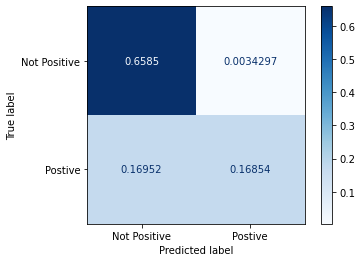

In [175]:
plot_confusion_matrix(pipe_cbc, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 5th Iteration: Neural Network with Regularization

In [176]:
#Sanity Check
X_train.head()

,Tweet
2320,make iphone case ttye time want show support
5622,come party google tonight link band food art i...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...


In [177]:
# Sets the sets as a Series Object
X_train = X_train["Tweet"]
X_val = X_val["Tweet"]

In [178]:
#Sanity Check
print(type(X_train))
print(type(X_val))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [179]:
#How long is our longest tweet
max_length = max([len(tweet.split()) for tweet in X_train])
max_length

18

In [180]:
# Instatiate the Tokenizer
k_tokenizer = keras.preprocessing.text.Tokenizer()

#fit the tokenizer
k_tokenizer.fit_on_texts(X_train)

#
X_train_token = k_tokenizer.texts_to_sequences(X_train)
X_val_token = k_tokenizer.texts_to_sequences(X_val)

In [181]:
#pads the tweets for equal length
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [182]:
#checks word length list
vocab_size = len(k_tokenizer.word_index) + 1
maxlen= 100
print(vocab_size)

7137


Following Function can be found here : https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review

In [183]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

GloVE file to large for Git Hub, can be found here: https://nlp.stanford.edu/projects/glove/

In [184]:
#sets the embedding dimensions
embedding_dim = 50
embedding_matrix = create_embedding_matrix('notebooks/dave/glove.6B.50d.txt',
                                           k_tokenizer.word_index, 
                                           embedding_dim)

In [185]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 50)            356850    
_________________________________________________________________
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dropout (Dropout)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 350)               315350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [186]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 3s 22ms/step - loss: 1.1595 - accuracy: 0.6708 - val_loss: 0.9081 - val_accuracy: 0.6659
Epoch 2/10
123/123 [==============================] - 2s 18ms/step - loss: 0.8406 - accuracy: 0.6760 - val_loss: 0.7893 - val_accuracy: 0.6663
Epoch 3/10
123/123 [==============================] - 2s 19ms/step - loss: 0.7570 - accuracy: 0.6901 - val_loss: 0.7300 - val_accuracy: 0.6928
Epoch 4/10
123/123 [==============================] - 2s 19ms/step - loss: 0.7194 - accuracy: 0.6997 - val_loss: 0.7309 - val_accuracy: 0.6663
Epoch 5/10
123/123 [==============================] - 2s 18ms/step - loss: 0.6899 - accuracy: 0.7123 - val_loss: 0.6943 - val_accuracy: 0.7173
Epoch 6/10
123/123 [==============================] - 2s 19ms/step - loss: 0.6690 - accuracy: 0.7399 - val_loss: 0.6840 - val_accuracy: 0.7246
Epoch 7/10
123/123 [==============================] - 2s 18ms/step - loss: 0.6564 - accuracy: 0.7451 - val_loss: 0.7175 - val_accuracy: 0.7021

In [187]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

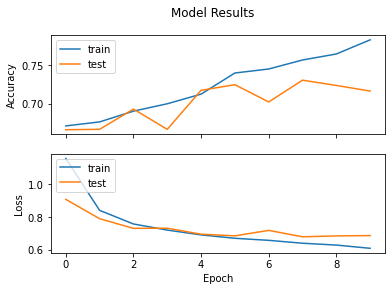

In [188]:
visualize_training_results(history)

## Evaluation

In [191]:
X_tr

,Tweet
233,Shouts to all the ladies holding up their iPad...
4022,Apple will be opening a temporary Apple Store ...
3438,Today's the day - join the Mobile Social ride ...
4597,I'm looking forward to our panel tomorrow (5pm...
8777,ProTip: Avoid the Austin-area Apple stores on ...
...,...
5734,RT @mention FREE #iTunes #SXSW ... link takes ...
5191,"RT @mention &quot;Transparency, choice and con..."
5390,RT @mention Anybody seen if the 6th St Apple s...
860,N33: They Love Me in This Town {link} [codes ...


In [192]:
X_test

,Tweet
5278,RT @mention #SXSW Come see Bitbop in Austin #g...
8080,12 #SXSW startup's elevator pitches in 12 minu...
6599,RT @mention RT @mention We interrupt your regu...
8206,Didn't get enough hacking on #startupbus? RSVP...
5244,RT @mention #Social Is Too Important For #Goog...
...,...
5883,RT @mention Google to Launch Major New Social ...
5710,RT @mention First day the exhibit hall is open...
637,Catch 22Û_ I mean iPad 2 at #SXSW - {link} #a...
3064,I21: No Rest for the Wicked {link} [codes vali...


In [193]:
#Create a pipeline to use an Tuned TfidfVectorizer() and MultinomialNB()
final_model = Pipeline(steps=[
    ('tfidf_vectorizer_tuned', TfidfVectorizer(max_df=.99,min_df=0.003, max_features=1000)),
    ('nb_tuned', MultinomialNB(alpha=.1))
])
#Cross validate
final_cv = cross_validate(pipe_nb_tuned, X_tr['Tweet'], y_tr, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
final_cv

{'fit_time': array([0.38602638, 0.16901231, 0.17001414, 0.1940167 , 0.21401572]),
 'score_time': array([0.20301485, 0.07800603, 0.21101475, 0.14600921, 0.08400559]),
 'test_accuracy': array([0.71034905, 0.72075934, 0.71078431, 0.71446078, 0.72058824]),
 'train_accuracy': array([0.74008271, 0.73655996, 0.74042879, 0.73966309, 0.73614089]),
 'test_recall': array([0.23364486, 0.19662921, 0.22846442, 0.22846442, 0.23220974]),
 'train_recall': array([0.27621723, 0.26953673, 0.28029949, 0.28076743, 0.27374825]),
 'test_roc_auc': array([0.72980355, 0.71871347, 0.71707326, 0.70314856, 0.70644618]),
 'train_roc_auc': array([0.77149711, 0.77573867, 0.77880846, 0.77710104, 0.77771588])}

In [194]:
final_cv['test_accuracy'].mean()

0.7153883445601144

In [195]:
final_model.fit(X_tr["Tweet"], y_tr)

Pipeline(steps=[('tfidf_vectorizer_tuned',
                 TfidfVectorizer(max_df=0.99, max_features=1000, min_df=0.003)),
                ('nb_tuned', MultinomialNB(alpha=0.1))])

In [196]:
cross_validate(final_model, X_tr, y_tr, return_train_score=True, scoring="recall")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 

{'fit_time': array([0.00499892, 0.00300026, 0.00399971, 0.00400019, 0.00500107]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan]),
 'train_score': array([nan, nan, nan, nan, nan])}

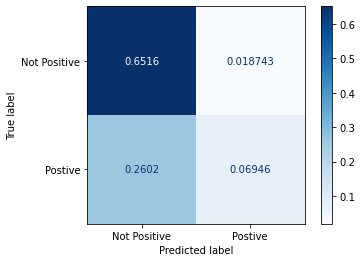

In [197]:
plot_confusion_matrix(final_model, X_test["Tweet"], y_test, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

In [ ]:
X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))